# Test custom visualizer

In [1]:
import tensorflow as tf
import pandas as pd
import importlib
import  numpy as np

# Set seed
tf.random.set_seed(42)

import custom_visualizer

## Load data

In [2]:
# Load dataloader
DATASET_PATH = "../processed_data/transformer_dataset"  # adjust if needed

ds = (tf.data.Dataset
      .load(DATASET_PATH)
      .batch(32)
      .prefetch(tf.data.AUTOTUNE))

In [3]:
def extract_subset(ds, k, split_id_filter=None, gameId=None, playId=None, frameId=None):
    """
    Extract up to `k` examples from the dataset `ds` that match the given filters,
    supporting batch sizes > 1.

    Args:
        ds (tf.data.Dataset): The dataset yielding (ids, X, y) tuples.
        split_id_filter (int): 0 for train, 1 for val, 2 for test.
        k (int): Number of items to retrieve (or all if less than k available).
        gameId (int, optional): Filter by gameId (ids[0]).
        playId (int, optional): Filter by playId (ids[1]).
        frameId (int, optional): Filter by frameId (ids[3]).

    Returns:
        List of tuples: [(ids, X, y), ...] with up to `k` items matching the filters.
    """
    result = []
    for batch in ds:
        ids_batch, X_batch, y_batch = batch  # shapes: (B, 4), (B, 100, 46), (B, 46)
        for i in range(ids_batch.shape[0]):
            ids = ids_batch[i]
            if split_id_filter is not None and ids[2].numpy() != split_id_filter:
                continue
            if gameId is not None and ids[0].numpy() != gameId:
                continue
            if playId is not None and ids[1].numpy() != playId:
                continue
            if frameId is not None and ids[3].numpy() != frameId:
                continue
            result.append((
                tf.expand_dims(ids, axis=0),             # shape (1, 4)
                tf.expand_dims(X_batch[i], axis=0),      # shape (1, 100, 46)
                tf.expand_dims(y_batch[i], axis=0),      # shape (1, 46)
            ))
            if len(result) == k:
                return result
    return result


In [4]:
# Load lookup table (parquet)
lookup = pd.read_parquet("../processed_data/train_test_val.parquet")
print(len(lookup))
lookup.head()


16124


,gameId,playId,split
0,2022101609,62,val
1,2022092505,370,val
2,2022103012,3611,train
3,2022100206,3038,train
4,2022110605,2543,test


In [5]:
# Get games from test
games_test = lookup[lookup['split']=='test']
print(len(games_test))
games_test.head()

3356


,gameId,playId,split
4,2022110605,2543,test
5,2022092512,1278,test
14,2022091109,1636,test
15,2022092508,322,test
16,2022100201,2105,test


In [6]:
# Get one random play ID from test games
gameId = games_test['gameId'].sample(1).values[0]
playId = games_test[games_test['gameId'] == gameId]['playId'].sample(1).values[0]
print(f"gameId: {gameId}, playId: {playId}")

gameId: 2022102300, playId: 2644


In [7]:
# Extract all sequences from the test set for the selected gameId and playId (about 2 min)
play_sequences = extract_subset(ds, k=None, playId=playId)
print(f"Number of sequences for playId {playId}: {len(play_sequences)}")
play_sequences

Number of sequences for playId 2644: 117


[(<tf.Tensor: shape=(1, 4), dtype=int32, numpy=array([[2022091900,       2644,          2,          1]])>,
  <tf.Tensor: shape=(1, 100, 46), dtype=float32, numpy=
  array([[[0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.26083332, 0.4120075 , 0.25358334, ..., 0.24502814,
           0.24758333, 0.44296438],
          [0.26083332, 0.4120075 , 0.25366667, ..., 0.24165103,
           0.24758333, 0.44296438]]], dtype=float32)>,
  <tf.Tensor: shape=(1, 46), dtype=float32, numpy=
  array([[0.26083332, 0.41219512, 0.25366667, 0.44296435, 0.2715    ,
          0.23414634, 0.26025   , 0.3752345 , 0.27608332, 0.6206379 ,
          0.

In [8]:
# Extract all the sequences from the test set (takes about 3 min)
test_sequences = extract_subset(ds, k=None, split_id_filter=2)
print(f"Number of sequences for test set: {len(test_sequences)}")
print("First sequence:")
test_sequences[0]

Number of sequences for test set: 89920
First sequence:


(<tf.Tensor: shape=(1, 4), dtype=int32, numpy=array([[2022091109,       2481,          2,          1]])>,
 <tf.Tensor: shape=(1, 100, 46), dtype=float32, numpy=
 array([[[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.14858334, 0.64596623, 0.1505    , ..., 0.36435273,
          0.1115    , 0.44465292],
         [0.14675   , 0.6553471 , 0.14958334, ..., 0.36210132,
          0.11141667, 0.44465292]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 46), dtype=float32, numpy=
 array([[0.14491667, 0.6643527 , 0.14858334, 0.30731708, 0.12266666,
         0.4664165 , 0.125     , 0.38311446, 0.15683334, 0.27579737,
         0.14233333, 0.554409 

In [9]:
# Drop all sequences in which the first vector has all zeros
old_n = len(test_sequences)
test_sequences = [seq for seq in test_sequences if not np.all(seq[1].numpy()[0, 0] == 0)]
print(f"Number of sequences dropped: {old_n - len(test_sequences)}")
print(f"Number of sequences for test set after dropping all-zero sequences: {len(test_sequences)}")

Number of sequences dropped: 55888
Number of sequences for test set after dropping all-zero sequences: 34032


In [11]:
# Convert test sequences to pandas DataFrame for easier manipulation
test_df = pd.DataFrame(test_sequences, columns=["ids", "X", "y"])

# Create columns for gameId, playId, and frameId
test_df["gameId"] = test_df["ids"].apply(lambda x: x[0].numpy()[0])
test_df["playId"] = test_df["ids"].apply(lambda x: x[0].numpy()[1])
test_df["frameId"] = test_df["ids"].apply(lambda x: x[0].numpy()[3])

# Drop IDs column
test_df = test_df.drop(columns=["ids"])

test_df.head()

,X,y,gameId,playId,frameId
0,"(((tf.Tensor(0.14858334, shape=(), dtype=float...","((tf.Tensor(0.082166664, shape=(), dtype=float...",2022091109,2481,1
1,"(((tf.Tensor(0.14675, shape=(), dtype=float32)...","((tf.Tensor(0.07958333, shape=(), dtype=float3...",2022091109,2481,2
2,"(((tf.Tensor(0.14491667, shape=(), dtype=float...","((tf.Tensor(0.077083334, shape=(), dtype=float...",2022091109,2481,3
3,"(((tf.Tensor(0.14316666, shape=(), dtype=float...","((tf.Tensor(0.074666664, shape=(), dtype=float...",2022091109,2481,4
4,"(((tf.Tensor(0.14141667, shape=(), dtype=float...","((tf.Tensor(0.072333336, shape=(), dtype=float...",2022091109,2481,5


In [12]:
# Get all the gameIds from the test set
gameIds = test_df['gameId'].unique()
print(f"Number of unique gameIds in the test set: {len(gameIds)}")
print(f"Unique gameIds: {gameIds}")

Number of unique gameIds in the test set: 5
Unique gameIds: [2022091109 2022091108 2022091107 2022091802 2022091900]


In [51]:
# Count the amount of frames per gameId and playId (transform)
test_df['frame_count'] = test_df.groupby(['gameId', 'playId'])['frameId'].transform('count')

# We have to add 100 to the frame count, because the last row has 100 frames in input plust the target
test_df['frame_count'] = test_df['frame_count'] + 100

# Value counts for count
print(test_df['frame_count'].value_counts())

test_df.head()

frame_count
190    720
178    702
186    688
168    680
161    671
      ... 
113     13
109      9
103      6
104      4
101      3
Name: count, Length: 137, dtype: int64


,X,y,gameId,playId,frameId,frame_count
0,"(((tf.Tensor(0.14858334, shape=(), dtype=float...","((tf.Tensor(0.082166664, shape=(), dtype=float...",2022091109,2481,1,170
1,"(((tf.Tensor(0.14675, shape=(), dtype=float32)...","((tf.Tensor(0.07958333, shape=(), dtype=float3...",2022091109,2481,2,170
2,"(((tf.Tensor(0.14491667, shape=(), dtype=float...","((tf.Tensor(0.077083334, shape=(), dtype=float...",2022091109,2481,3,170
3,"(((tf.Tensor(0.14316666, shape=(), dtype=float...","((tf.Tensor(0.074666664, shape=(), dtype=float...",2022091109,2481,4,170
4,"(((tf.Tensor(0.14141667, shape=(), dtype=float...","((tf.Tensor(0.072333336, shape=(), dtype=float...",2022091109,2481,5,170


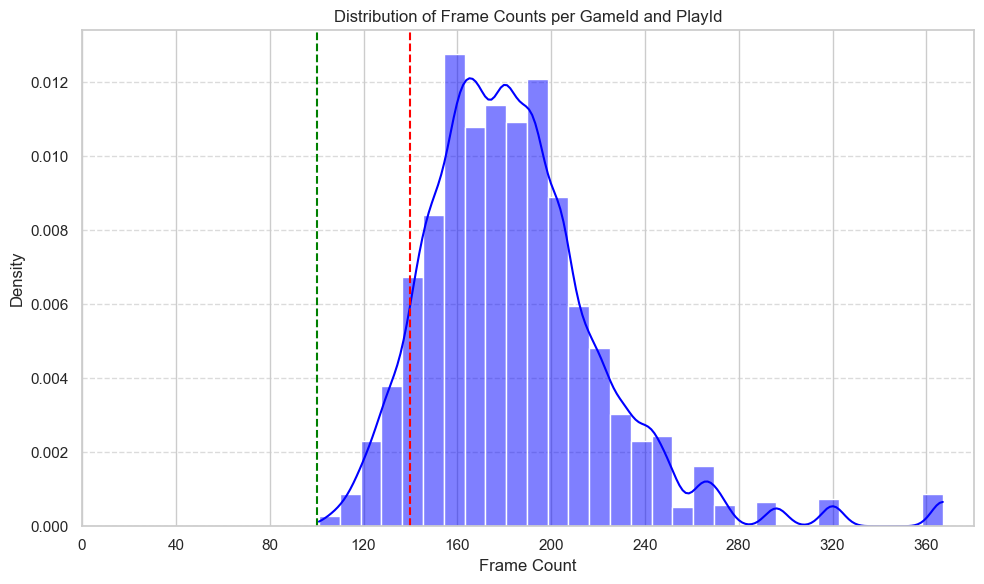

In [52]:
# Plot histogram of frame counts per gameId and playId
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# Set the style of seaborn
sns.set(style="whitegrid")

# Create a histogram of the frame counts
plt.figure(figsize=(10, 6))
sns.histplot(test_df['frame_count'], bins=30, kde=True, color='blue', stat='density')
# Vertical line at 140
plt.axvline(x=140, color='red', linestyle='--', label='140 frames')
# Vertical line at 100
plt.axvline(x=100, color='green', linestyle='--', label='100 frames')
plt.title('Distribution of Frame Counts per GameId and PlayId')
plt.xlabel('Frame Count')
plt.ylabel('Density')
plt.xticks(ticks=range(0, test_df['frame_count'].max() + 1, 5))  # Set x-ticks to be integers
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))  # Ensure x-ticks are integers
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [53]:
# Print the number of plays with at least 100 frames
print(f"Number of plays with at least 100 frames: {len(test_df[test_df['frame_count'] >= 100])}", "out of", len(test_df))
print(f"Number of plays with at least 140 frames: {len(test_df[test_df['frame_count'] >= 140])}", "out of", len(test_df))

Number of plays with at least 100 frames: 34032 out of 34032
Number of plays with at least 140 frames: 31350 out of 34032


In [54]:
# Select the frames from one random playId with at least 140 frames
playId = test_df[test_df['frame_count'] >= 140]['playId'].sample(1).values[0]
print(f"Selected playId: {playId}")
play_sequences = test_df[test_df['playId'] == playId]
print(f"Number of sequences for playId {playId}: {len(play_sequences)}")

play_sequences.head()

Selected playId: 2885
Number of sequences for playId 2885: 54


,X,y,gameId,playId,frameId,frame_count
6426,"(((tf.Tensor(0.21066667, shape=(), dtype=float...","((tf.Tensor(0.21033333, shape=(), dtype=float3...",2022091900,2885,1,154
6427,"(((tf.Tensor(0.21066667, shape=(), dtype=float...","((tf.Tensor(0.21033333, shape=(), dtype=float3...",2022091900,2885,2,154
6428,"(((tf.Tensor(0.21058333, shape=(), dtype=float...","((tf.Tensor(0.21041666, shape=(), dtype=float3...",2022091900,2885,3,154
6429,"(((tf.Tensor(0.2105, shape=(), dtype=float32),...","((tf.Tensor(0.21041666, shape=(), dtype=float3...",2022091900,2885,4,154
6430,"(((tf.Tensor(0.2105, shape=(), dtype=float32),...","((tf.Tensor(0.21058333, shape=(), dtype=float3...",2022091900,2885,5,154


## Testing

In [55]:
# Print the shape of one observation from train
# (try to get one of the last obsevations)
pct = 0.8
k = int(len(play_sequences) * pct)
print(f"Selected observation: {k}")

one_observation = play_sequences.iloc[k]

print("Shape of one observation from train set:", one_observation.shape)
print("Shape of the first column:", one_observation.iloc[0].shape)
print("Shape of the second column:", one_observation.iloc[1].shape)

# Look at the values from the columns
print("Values from the first column (ids):", one_observation.iloc[0].numpy())
print("Values from the second column (X):", one_observation.iloc[1].numpy())

Selected observation: 43
Shape of one observation from train set: (6,)
Shape of the first column: (1, 100, 46)
Shape of the second column: (1, 46)
Values from the first column (ids): [[[0.21       0.5330206  0.20425    ... 0.36885554 0.19883333 0.5613508 ]
  [0.21008334 0.5330206  0.20433334 ... 0.36866793 0.19883333 0.5613508 ]
  [0.21016666 0.53320825 0.20433334 ... 0.36866793 0.19883333 0.5613508 ]
  ...
  [0.27541667 0.51444656 0.25808334 ... 0.13489681 0.16491668 0.8075047 ]
  [0.27666667 0.51388365 0.25891668 ... 0.13114446 0.15508334 0.8300188 ]
  [0.27766666 0.5133208  0.25966668 ... 0.1283302  0.14541668 0.8521576 ]]]
Values from the second column (X): [[0.27858335 0.51275796 0.26008335 0.58705443 0.12216666 0.60281426
  0.1555     0.41801125 0.28191668 0.54727954 0.26633334 0.56979364
  0.04008333 0.6739212  0.24658333 0.60243905 0.18291667 0.1
  0.27325    0.6332083  0.14975    0.92026263 0.14825    0.39812383
  0.24566667 0.62908065 0.14033334 0.8801126  0.29041666 0.557223

(<Figure size 1200x670 with 1 Axes>, <Axes: >)

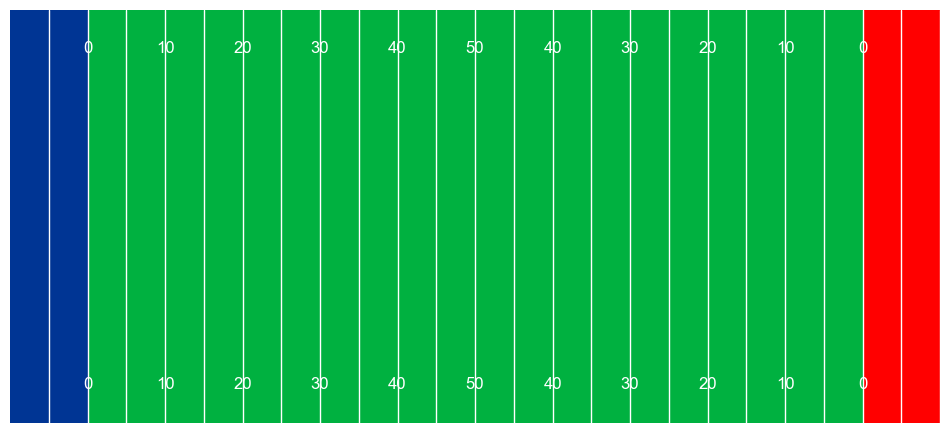

In [56]:
# reload the module to ensure the latest version is used
importlib.reload(custom_visualizer)

custom_visualizer.plot_pitch()

In [57]:
# reload the module to ensure the latest version is used
importlib.reload(custom_visualizer)

# Test function to extract the trajectory of one player
input_coordinates = one_observation.X[0]

traj = custom_visualizer.extract_player_trajectory(input_coordinates, 'offense', player_index=7)
traj

<tf.Tensor: shape=(100, 2), dtype=float32, numpy=
array([[0.36228892, 0.17875   ],
       [0.3619137 , 0.17858334],
       [0.3619137 , 0.17833333],
       [0.36210132, 0.17816667],
       [0.36172608, 0.17808333],
       [0.36172608, 0.17791666],
       [0.36153847, 0.17783333],
       [0.36135083, 0.17775   ],
       [0.36116323, 0.17766666],
       [0.36135083, 0.17775   ],
       [0.36153847, 0.17791666],
       [0.36153847, 0.17816667],
       [0.36153847, 0.1785    ],
       [0.36135083, 0.17891666],
       [0.36135083, 0.1795    ],
       [0.36116323, 0.18008333],
       [0.36116323, 0.18075   ],
       [0.36097562, 0.1815    ],
       [0.36097562, 0.18225   ],
       [0.360788  , 0.18308334],
       [0.360788  , 0.18341666],
       [0.360788  , 0.184     ],
       [0.360788  , 0.18425   ],
       [0.360788  , 0.1845    ],
       [0.360788  , 0.1845    ],
       [0.360788  , 0.185     ],
       [0.360788  , 0.1855    ],
       [0.360788  , 0.18533333],
       [0.360788  , 0.1854

In [58]:
# reload the module to ensure the latest version is used
importlib.reload(custom_visualizer)

# Test descaling function
input_coordinates = one_observation.X[0]

traj = custom_visualizer.extract_player_trajectory(input_coordinates, 'offense', player_index=7)
traj = custom_visualizer.descale_trajectory(traj)
traj

<tf.Tensor: shape=(100, 2), dtype=float32, numpy=
array([[43.47467  ,  9.527374 ],
       [43.429646 ,  9.518492 ],
       [43.429646 ,  9.505166 ],
       [43.452156 ,  9.496284 ],
       [43.407127 ,  9.491841 ],
       [43.407127 ,  9.482958 ],
       [43.384617 ,  9.478517 ],
       [43.3621   ,  9.474075 ],
       [43.33959  ,  9.469633 ],
       [43.3621   ,  9.474075 ],
       [43.384617 ,  9.482958 ],
       [43.384617 ,  9.496284 ],
       [43.384617 ,  9.51405  ],
       [43.3621   ,  9.536258 ],
       [43.3621   ,  9.567349 ],
       [43.33959  ,  9.598441 ],
       [43.33959  ,  9.633975 ],
       [43.317074 ,  9.67395  ],
       [43.317074 ,  9.713924 ],
       [43.29456  ,  9.758342 ],
       [43.29456  ,  9.776108 ],
       [43.29456  ,  9.8071995],
       [43.29456  ,  9.820525 ],
       [43.29456  ,  9.83385  ],
       [43.29456  ,  9.83385  ],
       [43.29456  ,  9.8605   ],
       [43.29456  ,  9.88715  ],
       [43.29456  ,  9.878266 ],
       [43.29456  ,  9.882

(<Figure size 1200x670 with 1 Axes>, <Axes: >)

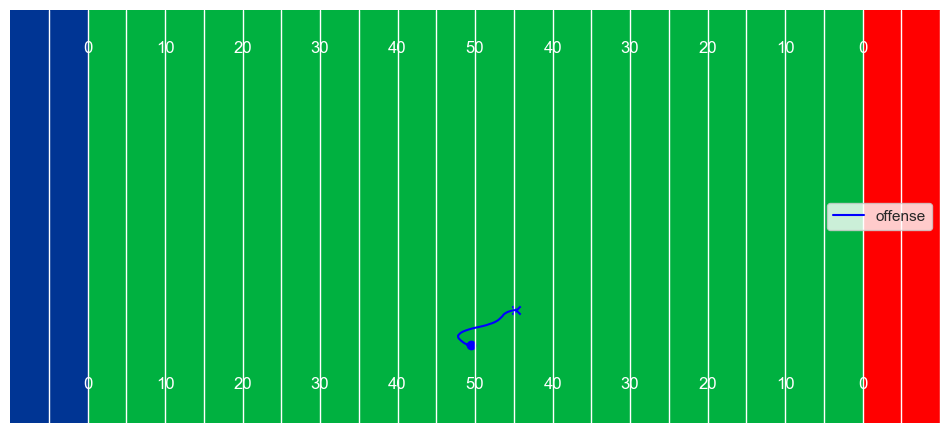

In [59]:
# reload the module to ensure the latest version is used
importlib.reload(custom_visualizer)

# Test plot_player_trajectory function
input_coordinates = one_observation.X[0]

traj = custom_visualizer.extract_player_trajectory(input_coordinates, 'offense', player_index=9)
traj = custom_visualizer.descale_trajectory(traj)
# print(traj)

custom_visualizer.plot_player_trajectory(traj, traj_label='offense')

(<Figure size 1200x670 with 1 Axes>, <Axes: >)

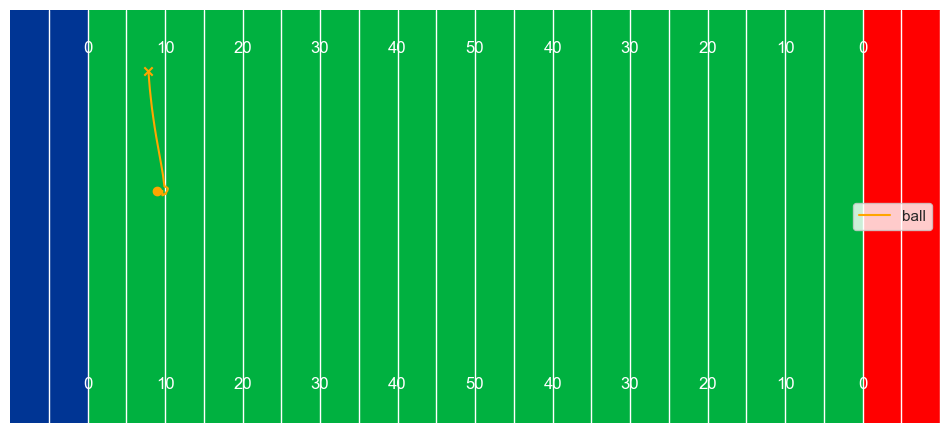

In [60]:
# reload the module to ensure the latest version is used
importlib.reload(custom_visualizer)

# Test plot_player_trajectory function
input_coordinates = one_observation.X[0]

traj = custom_visualizer.extract_player_trajectory(input_coordinates, team='ball', player_index=9)
traj = custom_visualizer.descale_trajectory(traj)
# print(traj)

custom_visualizer.plot_player_trajectory(traj, traj_label='ball')

(<Figure size 1200x670 with 1 Axes>, <Axes: >)

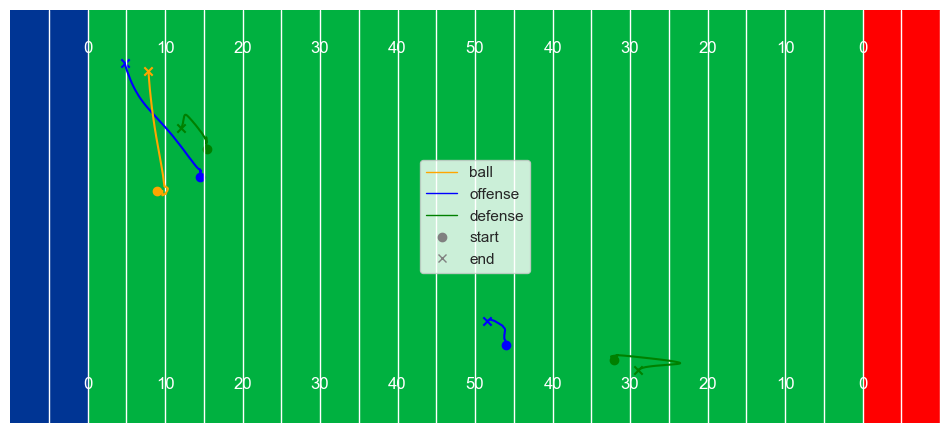

In [61]:
# reload the module to ensure the latest version is used
importlib.reload(custom_visualizer)

# Test function to plot trajectories of multiple players at once
input_coordinates = one_observation.X[0]

custom_visualizer.plot_trajectories(input_coordinates, offense=[1,4], defense=[2,5], include_ball=True)

(<Figure size 1200x670 with 1 Axes>, <Axes: >)

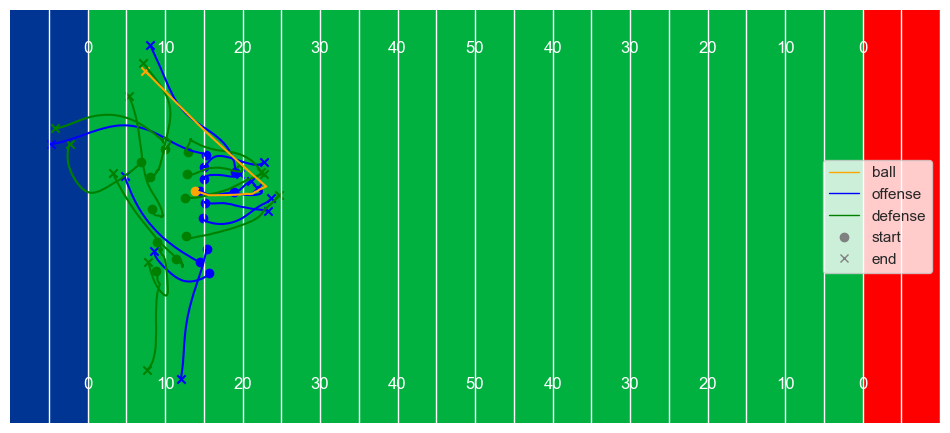

In [85]:
# reload the module to ensure the latest version is used
importlib.reload(custom_visualizer)

# Test function to plot trajectories of multiple players at once
input_coordinates = one_observation.X[0]

custom_visualizer.plot_trajectories(input_coordinates, offense='all', defense='all', include_ball=True)

## Now full trajectories
Now let's try making a differnce between input, ground truth and predicted

In [73]:
def extract_full_sequence(play_df):
    """
    Given a DataFrame for a single play (with columns ['frameId','X','y',…]),
    where each X is a tf.Tensor or array of shape (1, window_size, 46)
    and each y is (1, 46), returns a tf.Tensor of shape
    (1, total_frames, 46) spanning every frame, including the very last one.
    """
    # 1) sort windows by their starting frame
    df = play_df.sort_values('frameId').reset_index(drop=True)
    if df.empty:
        raise ValueError("play_df is empty!")
    
    # 2) extract X‐windows and final‐frame labels
    X_windows = df['X'].tolist()   # each (1, W, 46)
    y_labels   = df['y'].tolist()   # each (1, 46)
    
    # 3) normalize to tf.Tensor
    def to_tf(t):
        return t if isinstance(t, tf.Tensor) else tf.convert_to_tensor(t, tf.float32)
    X_windows = [to_tf(w) for w in X_windows]
    y_labels   = [to_tf(y) for y in y_labels]
    
    # 4) build the continuous sequence from X:
    #    - take all W frames from the first window
    sequence = X_windows[0][0]                # (W, 46)
    
    #    - for each subsequent window, append only its last frame
    if len(X_windows) > 1:
        tails = [w[0, -1, :] for w in X_windows[1:]]  # list of (46,)
        tails = tf.stack(tails, axis=0)               # (num_windows-1, 46)
        sequence = tf.concat([sequence, tails], axis=0)  # (frames_so_far, 46)
    
    # 5) now append the very last frame from y of the last row
    last_y = y_labels[-1]                # (1, 46)
    last_y = tf.expand_dims(last_y[0], axis=0)  # (1, 46)
    last_y = tf.expand_dims(last_y, axis=1)     # (1, 1, 46)
    
    # 6) re‐batch and concat on time axis
    full_seq = tf.expand_dims(sequence, axis=0)  # (1, frames_extracted, 46)
    full_seq = tf.concat([full_seq, last_y], axis=1)  # now (1, total_frames, 46)
    
    return full_seq



In [74]:
full_X = extract_full_sequence(play_sequences)
print(full_X.shape)   # → (1, #frames_in_play, 46)

(1, 154, 46)


(1, 154, 46)


(<Figure size 1200x670 with 1 Axes>, <Axes: >)

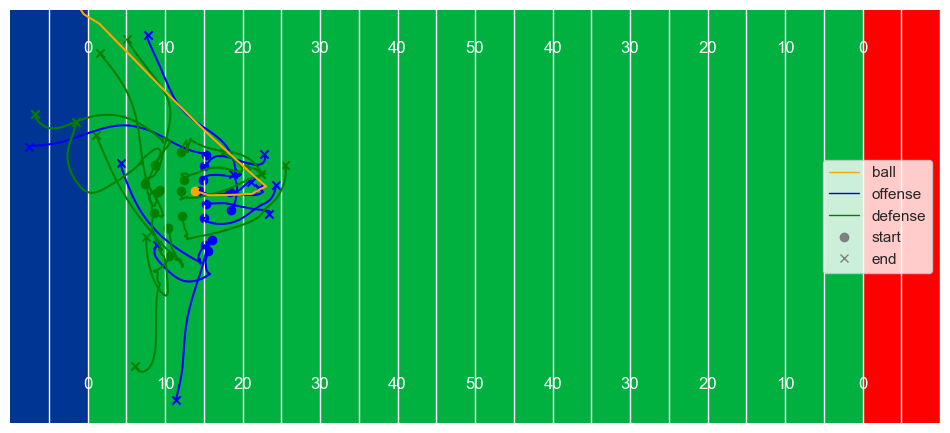

In [90]:
# reload the module to ensure the latest version is used
importlib.reload(custom_visualizer)

# Test function to plot trajectories of multiple players at once
full_X = extract_full_sequence(play_sequences)
print(full_X.shape)   # → (1, #frames_in_play, 46)

custom_visualizer.plot_trajectories(full_X, offense='all', defense='all', include_ball=True)


Selected playId: 1167
Number of sequences for playId 1167: 122
(1, 222, 46)


(<Figure size 1200x670 with 1 Axes>, <Axes: >)

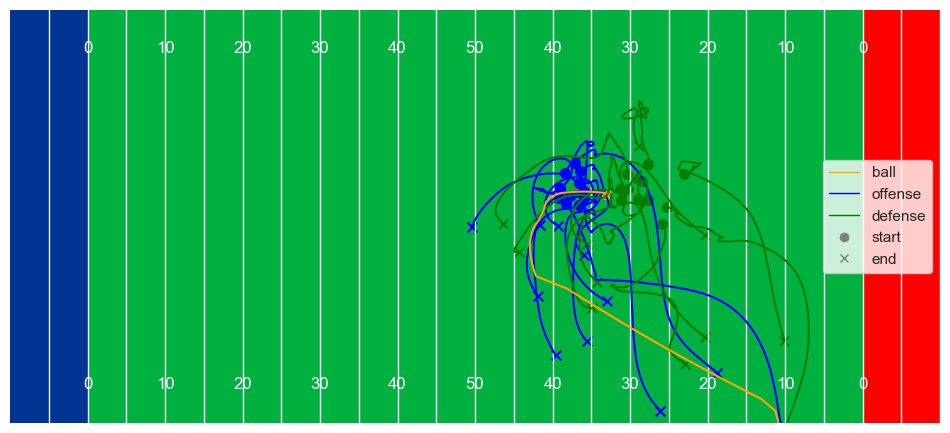

In [136]:
# Try a different play

# Select the frames from one random playId with at least 140 frames
playId = test_df[test_df['frame_count'] >= 140]['playId'].sample(1).values[0]
print(f"Selected playId: {playId}")
play_sequences2 = test_df[test_df['playId'] == playId]
print(f"Number of sequences for playId {playId}: {len(play_sequences2)}")

# reload the module to ensure the latest version is used
importlib.reload(custom_visualizer)

# Test function to plot trajectories of multiple players at once
full_X = extract_full_sequence(play_sequences2)
print(full_X.shape)   # → (1, #frames_in_play, 46)

custom_visualizer.plot_trajectories(full_X, offense='all', defense='all', include_ball=True)

Selected playId: 2541
Number of sequences for playId 2541: 85
(1, 185, 46)
(1, 85, 46)
First 2 values of first_X: tf.Tensor(
[[0.57475    0.53958726]
 [0.574      0.5393996 ]], shape=(2, 2), dtype=float32)
First 2 values of pred: tf.Tensor(
[[0.61125   0.5766417]
 [0.61125   0.5766417]], shape=(2, 2), dtype=float32)


(<Figure size 1200x670 with 1 Axes>, <Axes: >)

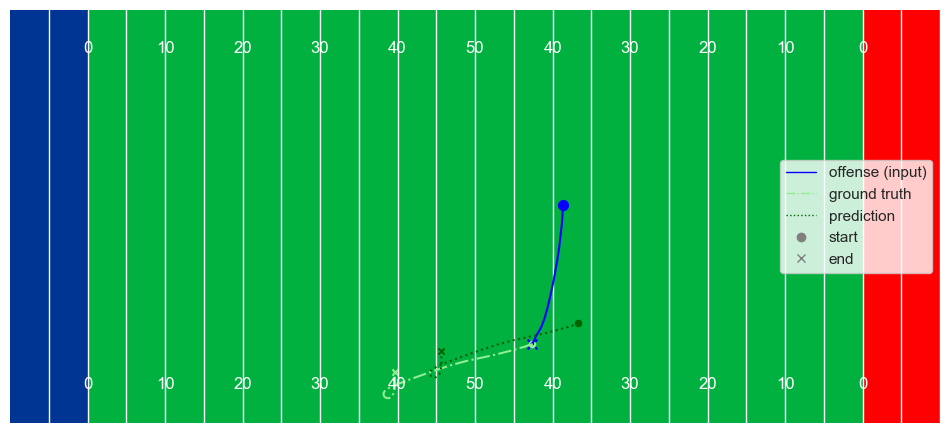

In [137]:
# Select the frames from one random playId with at least 140 frames
playId = 2541
print(f"Selected playId: {playId}")
play_sequences2 = test_df[test_df['playId'] == playId]
print(f"Number of sequences for playId {playId}: {len(play_sequences2)}")

# reload the module to ensure the latest version is used
importlib.reload(custom_visualizer)

full_X = extract_full_sequence(play_sequences2)
print(full_X.shape)

# Get the first 100 frames from full_X
first_X = full_X[:, :100, :]
# Get the subsequent frames until the end
subsequent_X = full_X[:, 100:, :]
# Simulate subsequent_X with some noise (just add 0.1 to each value)
offset = 0.05
pred = subsequent_X + tf.fill(subsequent_X.shape, offset)
print(pred.shape) 

# Print first 2 values of first_X and pred
print("First 2 values of first_X:", first_X[0, :2, :2])
print("First 2 values of pred:", pred[0, :2, :2])

custom_visualizer.plot_trajectories(
    sequence=first_X,
    offense=[10],
    ground_truth_seq=subsequent_X,
    pred_seq=pred,
    include_ball=False
)

Selected playId: 2426
Number of sequences for playId 2426: 86
(1, 186, 46)
(1, 86, 46)
First 2 values of first_X: tf.Tensor(
[[0.6850833  0.4326454 ]
 [0.685      0.43339586]], shape=(2, 2), dtype=float32)
First 2 values of pred: tf.Tensor(
[[0.73575   0.5002814]
 [0.7356667 0.5002814]], shape=(2, 2), dtype=float32)


(<Figure size 1200x670 with 1 Axes>, <Axes: >)

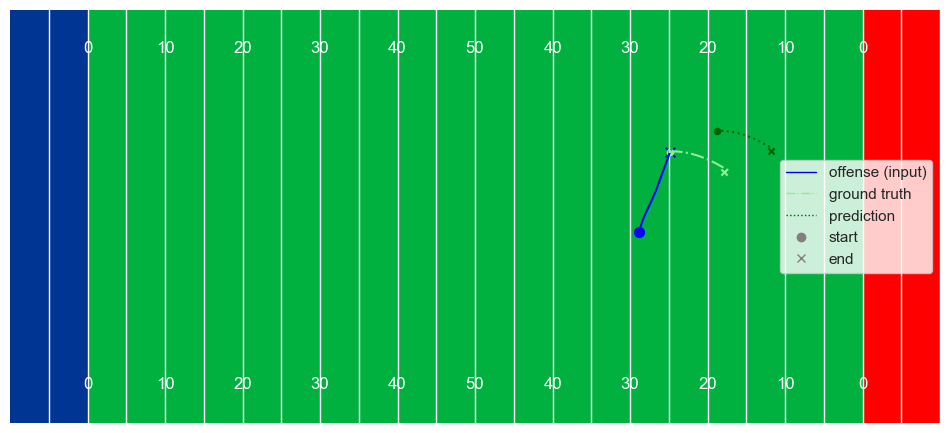

In [139]:
# Select the frames from one random playId with at least 140 frames
playId = test_df[test_df['frame_count'] >= 140]['playId'].sample(1).values[0]
print(f"Selected playId: {playId}")
play_sequences2 = test_df[test_df['playId'] == playId]
print(f"Number of sequences for playId {playId}: {len(play_sequences2)}")

# reload the module to ensure the latest version is used
importlib.reload(custom_visualizer)

full_X = extract_full_sequence(play_sequences2)
print(full_X.shape)

# Get the first 100 frames from full_X
first_X = full_X[:, :100, :]
# Get the subsequent frames until the end
subsequent_X = full_X[:, 100:, :]
# Simulate subsequent_X with some noise (just add 0.1 to each value)
offset = 0.05
pred = subsequent_X + tf.fill(subsequent_X.shape, offset)
print(pred.shape) 

# Print first 2 values of first_X and pred
print("First 2 values of first_X:", first_X[0, :2, :2])
print("First 2 values of pred:", pred[0, :2, :2])

custom_visualizer.plot_trajectories(
    sequence=first_X,
    offense=[10],
    ground_truth_seq=subsequent_X,
    pred_seq=pred,
    include_ball=False
)

Selected playId: 3598
Number of sequences for playId 3598: 71
(1, 171, 46)
First 2 values of first_X: tf.Tensor(
[[0.4035     0.56041276]
 [0.40158334 0.56979364]], shape=(2, 2), dtype=float32)
First 2 values of pred: tf.Tensor(
[[0.3588172  0.8089565 ]
 [0.3616243  0.81439215]], shape=(2, 2), dtype=float32)


(<Figure size 1200x670 with 1 Axes>, <Axes: >)

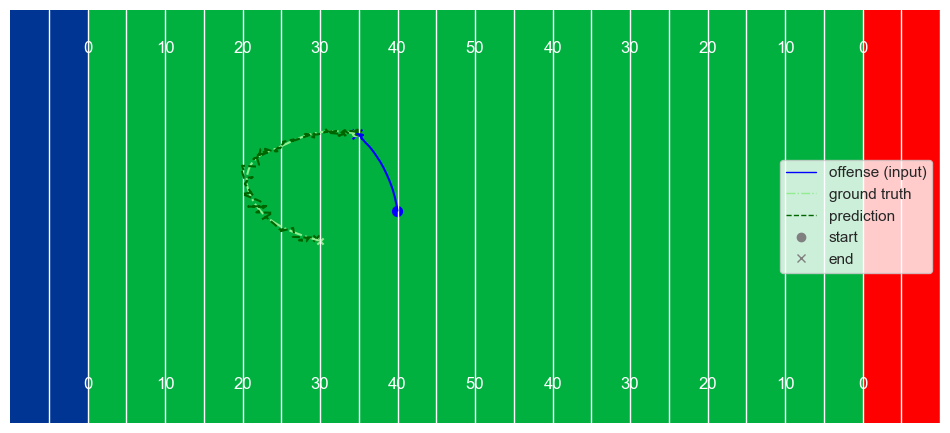

In [150]:
# Select the frames from one random playId with at least 140 frames
playId = test_df[test_df['frame_count'] >= 140]['playId'].sample(1).values[0]
print(f"Selected playId: {playId}")
play_sequences2 = test_df[test_df['playId'] == playId]
print(f"Number of sequences for playId {playId}: {len(play_sequences2)}")

# reload the module to ensure the latest version is used
importlib.reload(custom_visualizer)

full_X = extract_full_sequence(play_sequences2)
print(full_X.shape)

# Get the first 100 frames from full_X
first_X = full_X[:, :100, :]
# Get the subsequent frames until the end
subsequent_X = full_X[:, 100:, :]
# Add very small random noise around zero
noise_scale = 0.01  # much smaller noise
noise = tf.random.uniform(subsequent_X.shape, minval=-noise_scale, maxval=noise_scale)

# Simulated prediction: ground truth + small noise
pred = subsequent_X + noise

# Print first 2 values of first_X and pred
print("First 2 values of first_X:", first_X[0, :2, :2])
print("First 2 values of pred:", pred[0, :2, :2])

custom_visualizer.plot_trajectories(
    sequence=first_X,
    offense=[1],
    ground_truth_seq=subsequent_X,
    pred_seq=pred,
    include_ball=False
)

In [142]:
noise.shape

TensorShape([1, 172, 46])

In [141]:
subsequent_X.shape

TensorShape([1, 172, 46])